# import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline






import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [5]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
    images, labels = dataiter.next()
    for j in range(batch_size):
        if(classes[labels[j]] in background_classes):
            img = images[j].tolist()
            background_data.append(img)
            background_label.append(labels[j])
        else:
            img = images[j].tolist()
            foreground_data.append(img)
            foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img#.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


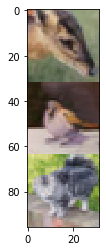

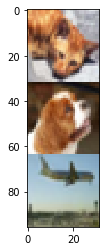

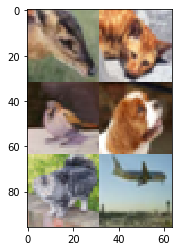

torch.Size([3, 96, 32])


In [7]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())

In [8]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
    """
      bg_idx : list of indexes of background_data[] to be used as background images in mosaic
      fg_idx : index of image to be used as foreground image from foreground data
      fg : at what position/index foreground image has to be stored out of 0-8
    """
    image_list=[]
    j=0
    for i in range(9):
        if i != fg:
            image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
            j+=1
        else: 
            image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
            label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
    #image_list = np.concatenate(image_list ,axis=0)
    image_list = torch.stack(image_list) 
    return image_list,label

In [9]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)


6


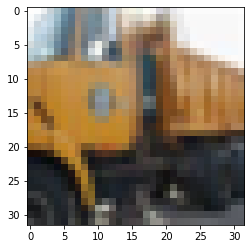

truck


In [10]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])

print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving


In [11]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""
    def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
        """
          Args:
          csv_file (string): Path to the csv file with annotations.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.mosaic = mosaic_list_of_images
        self.label = mosaic_label
        self.fore_idx = fore_idx
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

# Model

In [12]:
class Module1(nn.Module):
    def __init__(self):
        super(Module1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x = self.pool(x1)
        x = self.pool(F.relu(self.conv2(x1)))
        #print(x.shape)
        x = x.view(-1, 16 * 12* 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #print("sdfdsa",x.shape,x1.shape)
        return x,x1
      


In [13]:
class Module2(nn.Module):
    def __init__(self):
        super(Module2, self).__init__()
        self.module1 = Module1().double()
        self.module1 = self.module1.to(device)
        self.conv1 = nn.Conv2d(6, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4* 4,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)
        
        
    def forward(self,z):  #z batch of list of 9 images
        y = torch.zeros([batch,6, 28,28], dtype=torch.float64)
        x = torch.zeros([batch,9],dtype=torch.float64)
        x1 = torch.zeros([batch,9,6,28,28],dtype=torch.float64)
        y  = y.to(device)
        x1,x = x1.to(device),x.to(device)
        #print(x1.shape,x.shape)
       
        #z = z.type(torch.DoubleTensor)
        
        #print(z.shape,z.dtype)
        
        for i in range(9):
            k,l  =  self.module1.forward(z[:,i,:,:,:])
            x[:,i] = k[:,0]
            x1[:,i,:,:,:] = l
            #print(k.shape)
        #print("123",x.shape,x1.shape)

        x = F.softmax(x,dim=1)
        #print(x.shape)

        #x2 = x[:,0]
        
#         print((x[0,0]*x1[0])[None,:,:,:].shape,y.shape)
        
        for i in range(9):
            x2 = x[:,i]          
            y = y + torch.mul(x2[:,None,None,None],x1[:,i])
            

        y1 = self.pool(F.relu(self.conv1(y)))
        y1 = self.pool(F.relu(self.conv2(y1)))
        #print(y1.shape)
        y1 = y1.view(-1, 16 * 4* 4)

        y1 = F.relu(self.fc1(y1))
        y1 = F.relu(self.fc2(y1))
        y1 = F.relu(self.fc3(y1))
        y1 = self.fc4(y1)

        return y1 , x, y

In [14]:
fore_net = Module2().double()
fore_net = fore_net.to(device)

In [15]:
train_iter = iter(train_loader)
a,b,c = train_iter.next()
a,b,c = a.to(device),b.to(device),c.to(device)
print(a.shape,b.shape,c.shape)
output,conv_out,d = fore_net((a))
print(output.shape,conv_out.shape)

torch.Size([250, 9, 3, 32, 32]) torch.Size([250]) torch.Size([250])
torch.Size([250, 3]) torch.Size([250, 9])


In [16]:

test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [17]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

# training

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fore_net.parameters(), lr=0.001, momentum=0.9)

In [19]:
nos_epochs = 500
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer.zero_grad()

        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        #     print(outputs)
        #     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if cnt % 40 == 39:    # print every 40 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 40))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
                outputs, alphas, avg_images = fore_net(inputs)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        torch.save(fore_net.state_dict(),"model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(fore_net.state_dict(),"model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.099
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.099
[2,    80] loss: 1.099
[2,   120] loss: 1.099
[3,    40] loss: 1.099
[3,    80] loss: 1.099
[3,   120] loss: 1.099
[4,    40] loss: 1.099
[4,    80] loss: 1.099
[4,   120] loss: 1.099
[5,    40] loss: 1.099
[5,    80] loss: 1.099
[5,   120] loss: 1.099
[6,    40] loss: 1.099
[6,    80] loss: 1.099
[6,   120] loss: 1.099
[7,    40] loss: 1.099
[7,    80] loss: 1.099
[7,   120] loss: 1.099
[8,    40] loss: 1.099
[8,    80] loss: 1.099
[8,   120] loss: 1.099
[9,    40] loss: 1.099
[9,    80] loss: 1.099
[9,   120] loss: 1.099
[10,    40] loss: 1.099
[10,    80] loss: 1.099
[10,   120] loss: 1.099
[11,    40] loss: 1.099
[11,    80] loss: 1.099
[11,   120] loss: 1.099
[12,    40] loss: 1.099
[12,    80] loss: 1.099
[12,   120] loss: 1.099
[13,    40] loss: 1.099
[13,    80] loss: 1.099
[13,   120] loss: 1.099
[14,    40] loss: 1.099
[14,    80] loss: 1.099
[14,   120] loss: 1.099
[15,    40] loss: 1

[114,   120] loss: 1.098
[115,    40] loss: 1.098
[115,    80] loss: 1.098
[115,   120] loss: 1.098
[116,    40] loss: 1.098
[116,    80] loss: 1.098
[116,   120] loss: 1.098
[117,    40] loss: 1.098
[117,    80] loss: 1.098
[117,   120] loss: 1.098
[118,    40] loss: 1.098
[118,    80] loss: 1.098
[118,   120] loss: 1.098
[119,    40] loss: 1.098
[119,    80] loss: 1.098
[119,   120] loss: 1.098
[120,    40] loss: 1.098
[120,    80] loss: 1.098
[120,   120] loss: 1.098
[121,    40] loss: 1.098
[121,    80] loss: 1.098
[121,   120] loss: 1.098
[122,    40] loss: 1.098
[122,    80] loss: 1.098
[122,   120] loss: 1.098
[123,    40] loss: 1.098
[123,    80] loss: 1.098
[123,   120] loss: 1.098
[124,    40] loss: 1.098
[124,    80] loss: 1.098
[124,   120] loss: 1.098
[125,    40] loss: 1.098
[125,    80] loss: 1.098
[125,   120] loss: 1.098
[126,    40] loss: 1.098
[126,    80] loss: 1.098
[126,   120] loss: 1.098
[127,    40] loss: 1.098
[127,    80] loss: 1.098
[127,   120] loss: 1.098


[224,    40] loss: 1.058
[224,    80] loss: 1.046
[224,   120] loss: 1.052
[225,    40] loss: 1.050
[225,    80] loss: 1.050
[225,   120] loss: 1.051
[226,    40] loss: 1.041
[226,    80] loss: 1.053
[226,   120] loss: 1.055
[227,    40] loss: 1.047
[227,    80] loss: 1.053
[227,   120] loss: 1.048
[228,    40] loss: 1.049
[228,    80] loss: 1.048
[228,   120] loss: 1.047
[229,    40] loss: 1.049
[229,    80] loss: 1.048
[229,   120] loss: 1.045
[230,    40] loss: 1.043
[230,    80] loss: 1.049
[230,   120] loss: 1.046
[231,    40] loss: 1.046
[231,    80] loss: 1.046
[231,   120] loss: 1.041
[232,    40] loss: 1.045
[232,    80] loss: 1.041
[232,   120] loss: 1.046
[233,    40] loss: 1.048
[233,    80] loss: 1.040
[233,   120] loss: 1.041
[234,    40] loss: 1.044
[234,    80] loss: 1.043
[234,   120] loss: 1.039
[235,    40] loss: 1.043
[235,    80] loss: 1.042
[235,   120] loss: 1.036
[236,    40] loss: 1.042
[236,    80] loss: 1.040
[236,   120] loss: 1.037
[237,    40] loss: 1.038


[333,    80] loss: 0.292
[333,   120] loss: 0.313
[334,    40] loss: 0.281
[334,    80] loss: 0.307
[334,   120] loss: 0.300
[335,    40] loss: 0.265
[335,    80] loss: 0.283
[335,   120] loss: 0.280
[336,    40] loss: 0.280
[336,    80] loss: 0.265
[336,   120] loss: 0.285
[337,    40] loss: 0.286
[337,    80] loss: 0.268
[337,   120] loss: 0.267
[338,    40] loss: 0.259
[338,    80] loss: 0.255
[338,   120] loss: 0.265
[339,    40] loss: 0.252
[339,    80] loss: 0.261
[339,   120] loss: 0.268
[340,    40] loss: 0.256
[340,    80] loss: 0.244
[340,   120] loss: 0.255
[341,    40] loss: 0.268
[341,    80] loss: 0.253
[341,   120] loss: 0.253
[342,    40] loss: 0.236
[342,    80] loss: 0.276
[342,   120] loss: 0.251
[343,    40] loss: 0.227
[343,    80] loss: 0.234
[343,   120] loss: 0.257
[344,    40] loss: 0.204
[344,    80] loss: 0.230
[344,   120] loss: 0.222
[345,    40] loss: 0.200
[345,    80] loss: 0.216
[345,   120] loss: 0.248
[346,    40] loss: 0.211
[346,    80] loss: 0.230


[442,   120] loss: 0.059
[443,    40] loss: 0.050
[443,    80] loss: 0.050
[443,   120] loss: 0.062
[444,    40] loss: 0.058
[444,    80] loss: 0.057
[444,   120] loss: 0.054
[445,    40] loss: 0.033
[445,    80] loss: 0.037
[445,   120] loss: 0.044
[446,    40] loss: 0.042
[446,    80] loss: 0.043
[446,   120] loss: 0.046
[447,    40] loss: 0.038
[447,    80] loss: 0.036
[447,   120] loss: 0.058
[448,    40] loss: 0.043
[448,    80] loss: 0.046
[448,   120] loss: 0.049
[449,    40] loss: 0.039
[449,    80] loss: 0.033
[449,   120] loss: 0.036
[450,    40] loss: 0.025
[450,    80] loss: 0.026
[450,   120] loss: 0.031
[451,    40] loss: 0.043
[451,    80] loss: 0.059
[451,   120] loss: 0.055
[452,    40] loss: 0.047
[452,    80] loss: 0.053
[452,   120] loss: 0.050
[453,    40] loss: 0.044
[453,    80] loss: 0.044
[453,   120] loss: 0.046
[454,    40] loss: 0.058
[454,    80] loss: 0.054
[454,   120] loss: 0.062
[455,    40] loss: 0.051
[455,    80] loss: 0.051
[455,   120] loss: 0.050


In [22]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [23]:
df_train

epochs  argmax > 0.5  argmax < 0.5  focus_true_pred_true  \
0        4             0         30000                   748   
1        9             0         30000                   876   
2       14             0         30000                   993   
3       19             0         30000                   929   
4       24             0         30000                   956   
..     ...           ...           ...                   ...   
95     479         28241          1759                 25663   
96     484         28194          1806                 25595   
97     489         28123          1877                 25680   
98     494         28245          1755                 25733   
99     499         27963          2037                 25367   

    focus_false_pred_true  focus_true_pred_false  focus_false_pred_false  
0                    9323                   2751                   17178  
1                    9302                   2654                   17168  
2                    9038                   2564                   17405  
3                    9097                   2652                   17322  
4                    9210                   2646                   17188  
..                    ...                    ...                     ...  
95                   4068                     50                     219  
96                   4109                     47                     249  
97                   4101                     37                     182  
98                   4082                     19                     166  
99                   4127                    134                     372  

[100 rows x 7 columns]

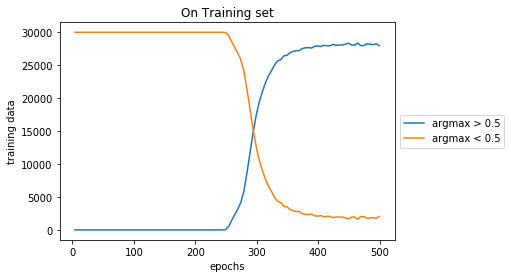

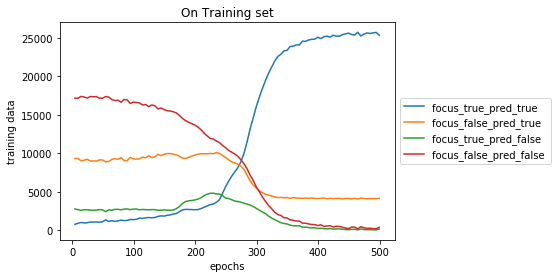

In [25]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [26]:
df_test

epochs  argmax > 0.5  argmax < 0.5  focus_true_pred_true  \
0        4             0         10000                   303   
1        9             0         10000                   309   
2       14             0         10000                   308   
3       19             0         10000                   314   
4       24             0         10000                   320   
..     ...           ...           ...                   ...   
95     479          8986          1014                  7689   
96     484          8992          1008                  7691   
97     489          8992          1008                  7733   
98     494          9018           982                  7732   
99     499          8956          1044                  7681   

    focus_false_pred_true  focus_true_pred_false  focus_false_pred_false  
0                    3045                    861                    5791  
1                    3046                    863                    5782  
2                    3040                    879                    5773  
3                    3034                    879                    5773  
4                    3028                    887                    5765  
..                    ...                    ...                     ...  
95                    903                    293                    1115  
96                    877                    292                    1140  
97                    861                    286                    1120  
98                    879                    271                    1118  
99                    853                    311                    1155  

[100 rows x 7 columns]

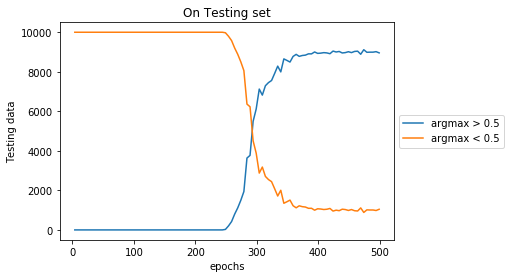

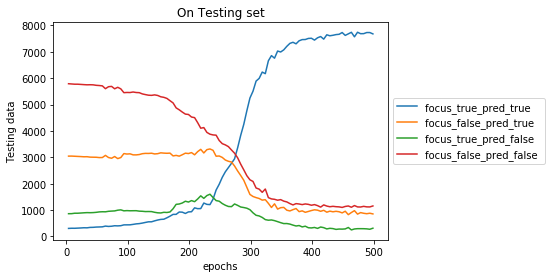

In [27]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [28]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13)

-------------------- Training Dataset --------------------
epochs [4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, 224, 229, 234, 239, 244, 249, 254, 259, 264, 269, 274, 279, 284, 289, 294, 299, 304, 309, 314, 319, 324, 329, 334, 339, 344, 349, 354, 359, 364, 369, 374, 379, 384, 389, 394, 399, 404, 409, 414, 419, 424, 429, 434, 439, 444, 449, 454, 459, 464, 469, 474, 479, 484, 489, 494, 499]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 508, 1458, 2332, 3184, 4219, 5974, 8764, 11842, 14879, 17479, 19496, 21009, 22352, 23415, 24211, 25106, 25673, 25855, 26430, 26502, 26910, 27094, 27211, 27211, 27540, 27645, 27659, 27606, 27861, 27910, 27834, 28013, 27941, 27954, 28153, 28008, 28060, 28056, 28196, 28332, 28058, 28046, 283

In [30]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])


     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 98 %
total correct 29517
total train set images 30000
focus_true_pred_true 25501
focus_false_pred_true 4016
focus_true_pred_false 122
focus_false_pred_false 361
argmax_more_than_half 27982
argmax_less_than_half 2018


In [33]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 10000 test images: 85 %
total correct 8534
total train set images 10000
focus_true_pred_true 7681
focus_false_pred_true 853
focus_true_pred_false 311
focus_false_pred_false 1155
argmax_more_than_half 8956
argmax_less_than_half 1044
